#Spam Filtering based on SVM  

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

In [ ]:
# data cleaning
def clean_text(text):
  # change to lower-case
  #text = str(text).lower()
  text = text.replace('\n', ' ')
  text = REPLACE_BY_SPACE_RE.sub(' ', text)
  text = list(text.split(' '))
  return text

In [ ]:
# read the IG data
df = pd.read_csv('terms.csv')
#df = pd.read_excel('terms.xlsx')
df.index = df['Unnamed: 0']
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# get topN terms, N = 10, 100, 1000
df_1 = df.iloc[0:10]
df_2 = df.iloc[0:100]
df_3 = df.iloc[0:1000]
#df_4 = df.iloc[0:5000]
df_1

,#spam with term,#legit with term,IG
Unnamed: 0,,,
language,7,1453,0.142768
remove,186,23,0.117098
free,253,138,0.113103
university,17,1276,0.100511
money,169,58,0.082261
click,117,13,0.070879
market,132,41,0.064122
business,143,67,0.060185
today,144,79,0.056415


##Binary features

First, I use the topN IG terms as selected features, then for each emails in folder 1 to 9, find whether each feature occurs and use this as training data. That is, for each terms, if it occurs in an email, the data corresponding to that feature should be 1, otherwise be 0. All the emails must have N features(N = 10, 100, 1000). Note that each email must have a label 0 or 1 correspond to ham or spam. Finally, using the folder 10 as test data.

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[+-_/(){}!^?<>"''\[\]\|,;:.]')

def get_data(df):
  train_data = {}
  features = list(df.index)

  for i in range(1, 10):
    root = '/content/drive/My Drive/Colab Notebooks/data/lemm_stop/part' + str(i)
    file_names = os.listdir(root)

    for file in file_names:
      data = []
      f = open(root + '/' + file, 'r')
      text = f.read()
      f.close()
      text = clean_text(text)
      text = list(set(text))
      if file[0] != 's':
        cls = 0
      else:
        cls = 1
      for feature in features:
        if feature in text:
          data.append(1)
        else:
          data.append(0)
      data.append(cls)
      train_data[file] = data
  return train_data

**N = 10**

In [ ]:
train_data = get_data(df_1)
features = list(df_1.index)
features.append('class')
dataset1 = pd.DataFrame(data=train_data.values(), index=train_data.keys(), columns=features)
dataset1.head()

,language,remove,free,university,money,click,market,business,today,$,class
3-378msg1.txt,0,0,0,0,0,0,0,0,0,0,0
3-375msg1.txt,1,0,0,1,1,0,0,0,0,0,0
3-1msg3.txt,0,0,0,0,0,0,0,0,0,0,0
3-1msg2.txt,1,0,0,1,0,0,0,0,0,0,0
3-378msg3.txt,0,0,0,0,0,0,0,0,0,0,0


(2602, 11)

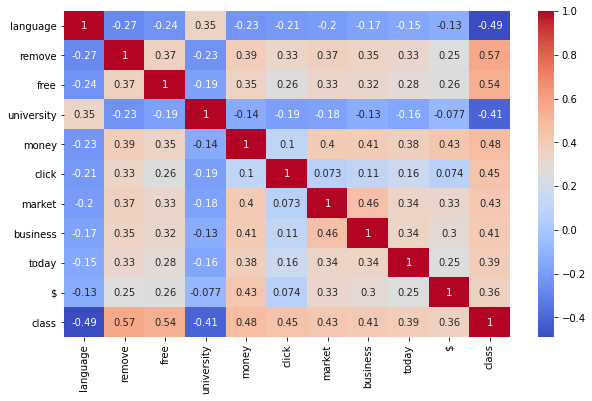

In [ ]:
# use hotmap to see the correlation between each feature
plt.figure(figsize=(10,6))
sns.heatmap(dataset1.corr(), annot=True, cmap='coolwarm')
dataset1.shape

In [ ]:
def model_stats(model, X_train, X_test, y_train, y_test):
  model = model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  print('\nModel used:', model)
  print('Precision: {}%'.format(precision*100))
  print('Recall: {}%'.format(recall*100))

In [ ]:
# get test data
def get_test(features):
  test_data = {}

  root = '/content/drive/My Drive/Colab Notebooks/data/lemm_stop/part10'
  file_names = os.listdir(root)

  for file in file_names:
    data = []
    f = open(root + '/' + file, 'r')
    text = f.read()
    f.close()
    text = clean_text(text)
    text = list(set(text))
    if file[0] != 's':
      cls = 0
    else:
      cls = 1
    for feature in features[:-1]:
      if feature in text:
        data.append(1)
      else:
        data.append(0)
    data.append(cls)
    test_data[file] = data
    
  return test_data

In [ ]:
test_data = get_test(features)
test_data1 = pd.DataFrame(data=test_data.values(), index=test_data.keys(), columns=features)
test_data1.head()

,language,remove,free,university,money,click,market,business,today,$,class
9-608msg2.txt,1,0,0,0,0,0,0,0,0,0,0
9-613msg1.txt,1,0,0,1,0,0,0,0,0,1,0
9-616msg1.txt,0,0,0,1,0,0,0,0,0,0,0
9-607msg1.txt,1,0,0,1,0,0,0,0,0,0,0
9-59msg1.txt,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
# train data
X_train = dataset1.loc[:, dataset1.columns != 'class']
y_train = dataset1['class']
X_test = test_data1.loc[:, test_data1.columns != 'class']
y_test = test_data1['class']

model = LinearSVC()
model_stats(model, X_train, X_test, y_train, y_test)


Model used: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Precision: 88.63636363636364%
Recall: 79.59183673469387%


In [ ]:
model = SVC(kernel='linear')
model_stats(model, X_train, X_test, y_train, y_test)


Model used: SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Precision: 88.88888888888889%
Recall: 81.63265306122449%


**N = 100**

In [ ]:
# get train data
train_data = get_data(df_2)
features = list(df_2.index)
features.append('class')
dataset2 = pd.DataFrame(data=train_data.values(), index=train_data.keys(), columns=features)
dataset2.head()

,language,remove,free,university,money,click,market,business,today,$,advertise,product,company,sell,million,english,internet,%,income,easy,save,guarantee,thousand,best,check,cash,purchase,buy,win,day,bulk,cost,dollar,every,mailing,edu,service,#,com,ll,...,amaze,credit,start,sale,live,toll,department,financial,anywhere,online,dream,science,huge,structure,friend,simply,ad,week,wait,study,fresh,security,analysis,xxx,marketing,off,topic,ship,home,line,profitable,secret,instruction,legal,package,excite,spend,research,debt,class
3-378msg1.txt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3-375msg1.txt,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3-1msg3.txt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3-1msg2.txt,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3-378msg3.txt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# get test data
test_data = get_test(features)
test_data = pd.DataFrame(data=test_data.values(), index=test_data.keys(), columns=features)
test_data.head()

,language,remove,free,university,money,click,market,business,today,$,advertise,product,company,sell,million,english,internet,%,income,easy,save,guarantee,thousand,best,check,cash,purchase,buy,win,day,bulk,cost,dollar,every,mailing,edu,service,#,com,ll,...,amaze,credit,start,sale,live,toll,department,financial,anywhere,online,dream,science,huge,structure,friend,simply,ad,week,wait,study,fresh,security,analysis,xxx,marketing,off,topic,ship,home,line,profitable,secret,instruction,legal,package,excite,spend,research,debt,class
9-608msg2.txt,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
9-613msg1.txt,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
9-616msg1.txt,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9-607msg1.txt,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9-59msg1.txt,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
# train
X_train = dataset2.loc[:, dataset2.columns != 'class']
y_train = dataset2['class']
X_test = test_data.loc[:, test_data.columns != 'class']
y_test = test_data['class']

model = LinearSVC()
model_stats(model, X_train, X_test, y_train, y_test)


Model used: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Precision: 88.63636363636364%
Recall: 79.59183673469387%


In [ ]:
model = SVC(kernel='linear')
model_stats(model, X_train, X_test, y_train, y_test)


Model used: SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Precision: 86.36363636363636%
Recall: 77.55102040816327%


**N = 1000**

In [ ]:
# get train data
train_data = get_data(df_3)
features = list(df_3.index)
features.append('class')
dataset3 = pd.DataFrame(data=train_data.values(), index=train_data.keys(), columns=features)
dataset3.head()

,language,remove,free,university,money,click,market,business,today,$,advertise,product,company,sell,million,english,internet,%,income,easy,save,guarantee,thousand,best,check,cash,purchase,buy,win,day,bulk,cost,dollar,every,mailing,edu,service,#,com,ll,...,community,old,resident,employee,option,drive,initial,privately,bag,appeal,appreciate,scale,matter,basic,member,belief,implement,identification,lunch,priority,section,integrate,jean,resolution,core,hawthorne,difference,choice,century,previous,light,chart,larger,promote,interview,advance,component,asium,tea,class
3-378msg1.txt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3-375msg1.txt,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3-1msg3.txt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3-1msg2.txt,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3-378msg3.txt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# get test data
test_data = get_test(features)
test_data = pd.DataFrame(data=test_data.values(), index=test_data.keys(), columns=features)
test_data.head()

,language,remove,free,university,money,click,market,business,today,$,advertise,product,company,sell,million,english,internet,%,income,easy,save,guarantee,thousand,best,check,cash,purchase,buy,win,day,bulk,cost,dollar,every,mailing,edu,service,#,com,ll,...,community,old,resident,employee,option,drive,initial,privately,bag,appeal,appreciate,scale,matter,basic,member,belief,implement,identification,lunch,priority,section,integrate,jean,resolution,core,hawthorne,difference,choice,century,previous,light,chart,larger,promote,interview,advance,component,asium,tea,class
9-608msg2.txt,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
9-613msg1.txt,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9-616msg1.txt,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9-607msg1.txt,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9-59msg1.txt,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# train data
X_train = dataset3.loc[:, dataset3.columns != 'class']
y_train = dataset1['class']
X_test = test_data.loc[:, test_data.columns != 'class']
y_test = test_data1['class']

model = LinearSVC()
model_stats(model, X_train, X_test, y_train, y_test)


Model used: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Precision: 97.61904761904762%
Recall: 83.6734693877551%


In [ ]:
model = SVC(kernel='linear')
model_stats(model, X_train, X_test, y_train, y_test)


Model used: SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Precision: 97.5609756097561%
Recall: 81.63265306122449%


**SVM_Binary:**

N = 10:  Precision: 88.9%; 
Recall: 81.6%

N = 100:  Precision: 95.3%; 
Recall: 83.7%

N = 1000:  Precision: 100.0%; 
Recall: 93.88%